# Introduction

This is a basic pseudo-code outline for how to perform basic reduction and calibration on HRPO data. You will need to write the code and reduction processes using CCDproc and the other appropriate packages.

# Code outline

1. Import necessary packages
2. Gather all data
3. Prepare for reduction
    - Make master bias
    - Make master dark
    - Make master flat(s)
4. Reduce the data
    - Use ccd_process to perform reduction and calibration
    - Optional: Plate solve images
    - Write out calibrated and solved data to a different directory, or with a different name
---

### Name: 
0. Rename this notebook so that it has your name in it and put your name in the comment above.
1. Import all of the necessary packages:
    - os
    - sys
    - numpy
    - ccdproc
    - astropy.units
    - aperturePhot.show_image
    

In [73]:
%matplotlib inline

import sys
sys.path.append('/home/idies/workspace/Storage/Dakota_Peltzer/persistent/hrpo-pipeline') #Change this so that it is your hrpo-pipeline directory.
import aperturePhot as ap

import numpy as np
import ccdproc as ccdp

#from astropy.nddata import CCDData
import os
from pathlib import Path

import astropy.units 

2. Gather all data

Define a string to store the path to the data directory you are working in.
Use *os.path.join* to merge together the string "/home/idies/workspace/" with the data directory path string.

Use *os.chdir* to move into the data directory. This will let us use relative paths instead of absolute.

`
base = "/home/idies/workspace/"
data_dir = ""

path = os.path.join(...)
os.chdir(path)
`

Use the conditional *os.path.exists* to check if there is a directory called "reduced" in the current directory. If there isn't, then make it with os.mkdir

In python you can check a condition with an if statement such as:

`
if condition:
     do something
`
Use *ccdp.ImageFileCollection* on the current directory to get a list of of all the images in the current directory as strings. I refer to this complete collection as *images*
`
images = ccdp.ImageFileCollection(...)
`


In [74]:
os.chdir('/home/idies/workspace/Temporary/Dakota_Peltzer/scratch/20220125')

In [75]:
base = "/home/idies/workspace/"

data_dir = "Temporary/Dakota_Peltzer/scratch/20220125"

path = os.path.join(base,data_dir)

os.chdir(path)

if not os.path.exists("reduced"):
    os.mkdir("reduced")

images = ccdp.ImageFileCollection('/home/idies/workspace/Temporary/Dakota_Peltzer/scratch/20220125')
print(images.summary)
#path ='/home/idies/workspace/Temporary/Dakota_Peltzer/scratch/20220125'

       file       simple bitpix ... flipstat         swowner          filter 
----------------- ------ ------ ... -------- ----------------------- --------
     Bias-001.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-002.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-003.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-004.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-005.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-006.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-007.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-008.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-009.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Bias-010.fit   True     16 ...          LSU Physics-Astronomy-1       --
     Dark-001.fit   True     16 ...          LSU Physics-Astrono

3. Reduction Preparation: Make master bias

Use *images.filter* to get only the images with *imagetyp="Bias Frame"*.

Create a master bias frame with *ccdp.combine* on your list of bias frames. Use the median method and specify that *unit="adu"*. I will refer to this master bias frame as *mbias*

Save the master bias with *mbias.write* to "reduced/mbias.fit", flag write to *overwrite=True* in case we rerun this entire script on this same directory multiple times.

`
biases = images.filter( ... )
mbias = ccdp.combine(biases, ... )
mbias.write( ...)
`

794.2675347328186 1.4826
788.0 804.0


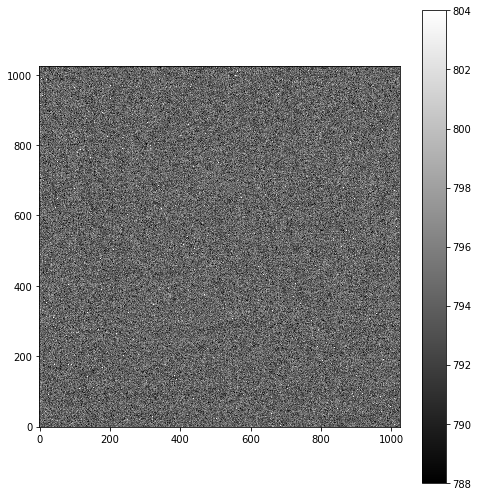

In [95]:
biases = images.files_filtered(imagetyp = "Bias Frame" )

mbias = ccdp.combine(biases, method = 'median', unit = 'adu' )

mbias.write("reduced/mbias.fit",overwrite = True)

ap.showimage(mbias)

4. Reduction Preparation: Make master dark

Use images.files_filtered to get only the images with imagetyp="Dark Frame". I will refer to this collection as *darks*.

Create two empty lists, one to store the reduced darks and one to store the exposure time of each frame. I will refer to this as *exptimes*

Use a for loop to iterate over *darks.ccds* . Subtract the *mbias* from each image with *ccdp.subtract_bias* and append it to the first empty list, append to the second empty list the exposure time from the header.

```
exptimes = []
red_darks = []
darks = filtered collection


for ccd in darks.ccds():
    ccd = bias subtracted dark
    Append the cleaned ccd to the red_darks list
    Append ccd.header["exptime"] to the exposure time list.
```

After this, convert your exposure times list to a numpy array. 

Create master dark frame with *ccdp.combine*. Use the median method, set *scale=1/exptimes*, and set *unit="adu"*. I will refer to this as *mdark*

Set the "exposure" and "exptime" header keywords in *mdark.header* to 1.

Save *mdark* in the reduced data directory.

```
exptimes = np.array(exptimes)
mdark = ccdp.combine (red_darks, ...)
mdark.header["exptime"] = 1
mdark.header["exposure"] = 1

mdark.write(...)

```

0.5160447597503662 0.37065
-0.6000000000000001 2.585747592118396


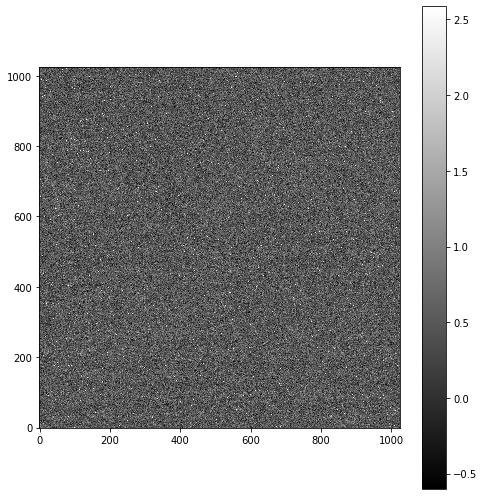

In [94]:
darks = images.filter(imagetyp = "Dark Frame")

exptimes = []
red_darks = []



for dark in darks.ccds(ccd_kwargs = {"unit":"adu"}):
    ccd = ccdp.subtract_bias(dark, mbias)
    red_darks.append(ccd)
    exptimes.append(ccd.header["exptime"]) 

exptimes = np.array(exptimes)
mdark = ccdp.combine(red_darks, method = 'median', scale=1/exptimes, unit = 'adu')
mdark.header["exptime"] = 1
mdark.header["exposure"] = 1

mdark.write("reduced/mdark.fit",overwrite = True)

ap.showimage(mdark)

5. Reduction Preparation: Make the master flat frames

Flat frames have the added complication that they are specific to each filter. Using nested for loops, we can save from writing the same code multiple times.

Define a list of filter names as strings

Create an empty dictionary to store our master flats for later.

Iterate over the filters in the outer loop.

Use *images.files_filtered* with *imagetyp="Flat Field"* as well as *filter=filt*.

Create empty list to store reduced flats.

Iterate over the flat ccds. Bias subtract, dark subtract with *scale=True, exposure_unit=u.s, exposure_time='exptime'*.

Append reduced flat to *red_flats*.

I present one way to make a unique filename for each filter's flat. There are a variety of things you can do here though.

Use *ccdp.combie* on the reduced flats. Write out the flat to the reduced directory with the filename.

Add a memory copy of the mflat to the dictionary with the key set to the filter name.

```
filters = ["Bessel B", "Bessel V", "Bessel R"]
mflats = {}

for filt in filters:
    flats = files.filter( ... )
    red_flats = []
    
    for flat in flats.ccds():
        flat = bias subtract
        flat = dark subtract, scale=True, exposure_unit=u.s
        Append flat to red_flats
    
    filt_string = filter.replace(" ", "_")
    fname = filt_string+"flat.fit"
    
    mflat = ccdp.combine(red_flats, ...)
    mflat.write(...)
    mflats[filt] = mflat.copy()
```

[CCDData([[15233., 15144., 15364., ..., 15307., 15078., 15148.],
         [15334., 15369., 15189., ..., 15075., 15119., 15205.],
         [15269., 15460., 15311., ..., 15015., 15079., 15216.],
         ...,
         [15201., 15268., 15184., ..., 15123., 15251., 15378.],
         [15263., 15197., 15157., ..., 15294., 15312., 15194.],
         [15321., 15356., 15262., ..., 15186., 15210., 15240.]], unit='adu'), CCDData([[15294., 15280., 15283., ..., 15153., 15289., 15207.],
         [15351., 15463., 15435., ..., 15270., 15130., 15206.],
         [15448., 15582., 15451., ..., 15249., 15103., 15248.],
         ...,
         [15231., 15365., 15359., ..., 15293., 15417., 15356.],
         [15282., 15267., 15299., ..., 15422., 15552., 15321.],
         [15437., 15179., 15346., ..., 15448., 15400., 15309.]], unit='adu'), CCDData([[15236., 15512., 15312., ..., 15269., 15382., 15302.],
         [15409., 15365., 15520., ..., 15126., 15264., 15306.],
         [15518., 15636., 15556., ..., 15262., 

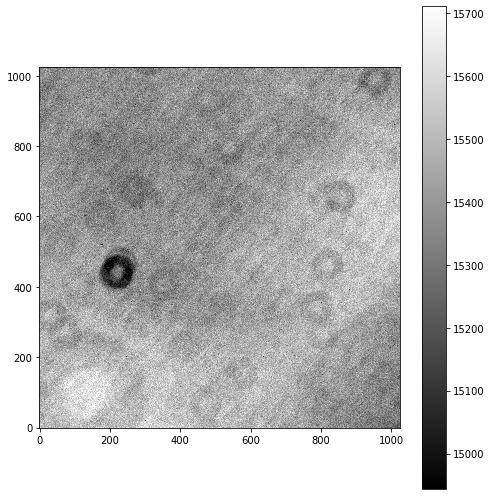

In [96]:
filters = ["Bessel V"]
mflats = {}

#print(images.summary)

for filt in filters:
    flats = images.filter(object="Domeflat", filter=filt)
    red_flats = []
    
    #print(flats.summary)
    
    for flat in flats.ccds(ccd_kwargs = {"unit":"adu"}):
        flat = ccdp.subtract_bias(flat,mbias)
        flat = ccdp.subtract_dark(flat,mdark, scale=True, exposure_unit=u.s, exposure_time='exptime')
        red_flats.append(flat)
    
    filt_string = filt.replace(" ", "_")
    fname = filt_string+"flat.fit"
    
    print(red_flats)
    
    mflat = ccdp.combine(red_flats,method='median',unit='adu')
    mflat.write("reduced/%s.fit" % (filt), overwrite= True)
    mflats[filt] = mflat.copy()

ap.showimage(mflat)

6. Reduce the data

Grab a list of all of the imagetyp="Light Frame".

Iterate over the Light Frame ccds.

Use the all-in-one *ccdp.ccd_process* on the ccd with *master_bias=mbias*, *dark_frame=mdark*, *master_flat=mflats[ccd.header["Filter"]]* ,*dark_scale=True, exposure_unit=u.s, exposure_key='exptime' *

Write out the reduced ccd to the reduced data directory
```
lights = ccdp.filter( ... )

for light in lights.ccds():
    light = ccdp.ccd_process( ...)
    light.write( ...)
```

In [93]:
lights = images.filter(imagetyp="Light Frame")

for light in lights.ccds():
    light = ccdp.ccd_process(master_bias=mbias, dark_frame=mdark, master_flat=mflats[ccd.header["Filter"]] ,dark_scale=True, exposure_unit=u.s, exposure_key='exptime' )
    light.write("reduced/light.fit", overwrite=True)